In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('./data/energy.csv')
data.head()

,timestamp,load,temp
0,2012-01-01 00:00:00,2698.0,32.000000
1,2012-01-01 01:00:00,2558.0,32.666667
2,2012-01-01 02:00:00,2444.0,30.000000
3,2012-01-01 03:00:00,2402.0,31.000000
4,2012-01-01 04:00:00,2403.0,32.000000


In [3]:
data.shape

(26304, 3)

In [4]:
data.tail()

,timestamp,load,temp
26299,2014-12-31 19:00:00,4012.0,18.000000
26300,2014-12-31 20:00:00,3856.0,16.666667
26301,2014-12-31 21:00:00,3671.0,17.000000
26302,2014-12-31 22:00:00,3499.0,15.333333
26303,2014-12-31 23:00:00,3345.0,15.333333


### 시간 정보 컬럼 파싱 - 시간 연산을 용이하게 한다.
- pandas의 parse_dates

In [190]:
energy = pd.read_csv('data/energy.csv', 
                     parse_dates=['timestamp'],
                    index_col='timestamp')

In [8]:
energy.head()

,load,temp
timestamp,,
2012-01-01 00:00:00,2698.0,32.000000
2012-01-01 01:00:00,2558.0,32.666667
2012-01-01 02:00:00,2444.0,30.000000
2012-01-01 03:00:00,2402.0,31.000000
2012-01-01 04:00:00,2403.0,32.000000


In [10]:
del energy['temp']

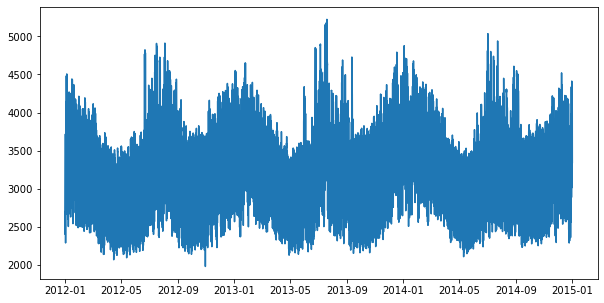

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(energy)

- 시계열 데이터는 순차적으로 데이터를 분리한다.
- 검증데이터(2개월), 평가데이터(2개월)
- MinmaxScaler로 0~1 사이 값으로 조정
- RNN 데이터구조로 변경

### 스케일링

In [192]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
result = scaler.fit_transform(energy)

In [194]:
energy

,load,temp
timestamp,,
2012-01-01 00:00:00,2698.0,32.000000
2012-01-01 01:00:00,2558.0,32.666667
2012-01-01 02:00:00,2444.0,30.000000
2012-01-01 03:00:00,2402.0,31.000000
2012-01-01 04:00:00,2403.0,32.000000
...,...,...
2014-12-31 19:00:00,4012.0,18.000000
2014-12-31 20:00:00,3856.0,16.666667
2014-12-31 21:00:00,3671.0,17.000000


In [193]:
result

array([[0.22157165, 0.4202454 ],
       [0.17842835, 0.42638037],
       [0.14329738, 0.40184049],
       ...,
       [0.52141757, 0.28220859],
       [0.46841294, 0.26687117],
       [0.42095532, 0.26687117]])

In [189]:
energy['load'] = result
#energy['load'] = result[0]
#energy['temp'] =result[1] 
# 스케일링한 값 덮어쓰기

### 데이터 SHIFT(RNN을 위한 구조 만들기)

In [100]:
energy_shifted = energy.copy()
energy_shifted['y_t+1'] = energy_shifted['load'].shift(-1, freq='H') # 위쪽으로 한 칸

In [101]:
energy_shifted.head() # y_t+1 : 정답 데이터

,load,temp,y_t+1
timestamp,,,
2012-01-01 00:00:00,2698.0,32.000000,2558.0
2012-01-01 01:00:00,2558.0,32.666667,2444.0
2012-01-01 02:00:00,2444.0,30.000000,2402.0
2012-01-01 03:00:00,2402.0,31.000000,2403.0
2012-01-01 04:00:00,2403.0,32.000000,2453.0


In [102]:
energy_shifted['load_t-5'] = energy_shifted['load'].shift(5, freq='H')
energy_shifted['load_t-4'] = energy_shifted['load'].shift(4, freq='H')
energy_shifted['load_t-3'] = energy_shifted['load'].shift(3, freq='H')
energy_shifted['load_t-2'] = energy_shifted['load'].shift(2, freq='H')
energy_shifted['load_t-1'] = energy_shifted['load'].shift(1, freq='H')
energy_shifted['load_t-0'] = energy_shifted['load'].shift(0, freq='H') # 현재 시간

energy_shifted.head(10)

# 6번 순환하는 RNN ( 과거 --> 현재 )

,load,temp,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t-0
timestamp,,,,,,,,,
2012-01-01 00:00:00,2698.0,32.000000,2558.0,NaN,NaN,NaN,NaN,NaN,2698.0
2012-01-01 01:00:00,2558.0,32.666667,2444.0,NaN,NaN,NaN,NaN,2698.0,2558.0
2012-01-01 02:00:00,2444.0,30.000000,2402.0,NaN,NaN,NaN,2698.0,2558.0,2444.0
2012-01-01 03:00:00,2402.0,31.000000,2403.0,NaN,NaN,2698.0,2558.0,2444.0,2402.0
2012-01-01 04:00:00,2403.0,32.000000,2453.0,NaN,2698.0,2558.0,2444.0,2402.0,2403.0
2012-01-01 05:00:00,2453.0,31.333333,2560.0,2698.0,2558.0,2444.0,2402.0,2403.0,2453.0
2012-01-01 06:00:00,2560.0,30.000000,2719.0,2558.0,2444.0,2402.0,2403.0,2453.0,2560.0
2012-01-01 07:00:00,2719.0,29.000000,2916.0,2444.0,2402.0,2403.0,2453.0,2560.0,2719.0
2012-01-01 08:00:00,2916.0,29.000000,3105.0,2402.0,2403.0,2453.0,2560.0,2719.0,2916.0


In [30]:
del energy_shifted['load']

In [37]:
energy_shifted.tail(10)

,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t-0
timestamp,,,,,,,
2014-12-31 13:00:00,0.589831,0.636055,0.646533,0.645300,0.632049,0.617257,0.602157
2014-12-31 14:00:00,0.595686,0.646533,0.645300,0.632049,0.617257,0.602157,0.589831
2014-12-31 15:00:00,0.666256,0.645300,0.632049,0.617257,0.602157,0.589831,0.595686
2014-12-31 16:00:00,0.721109,0.632049,0.617257,0.602157,0.589831,0.595686,0.666256
2014-12-31 17:00:00,0.684129,0.617257,0.602157,0.589831,0.595686,0.666256,0.721109
2014-12-31 18:00:00,0.626502,0.602157,0.589831,0.595686,0.666256,0.721109,0.684129
2014-12-31 19:00:00,0.578428,0.589831,0.595686,0.666256,0.721109,0.684129,0.626502
2014-12-31 20:00:00,0.521418,0.595686,0.666256,0.721109,0.684129,0.626502,0.578428
2014-12-31 21:00:00,0.468413,0.666256,0.721109,0.684129,0.626502,0.578428,0.521418


In [36]:
# 결측치 사용 불가 --> drop
energy_shifted.dropna(inplace=True)

### train, test, validation 분리

In [38]:
validation_start = '2014-09-01 00:00:00'
test_start = '2014-11-01 00:00:00'

In [52]:
train = energy_shifted.loc[energy_shifted.index<validation_start]
validation = energy_shifted.loc[(energy_shifted.index >= validation_start) & (energy_shifted.index<test_start)]
test = energy_shifted.loc[energy_shifted.index >= test_start]

In [53]:
train.shape, validation.shape, test.shape

((23371, 7), (1464, 7), (1463, 7))

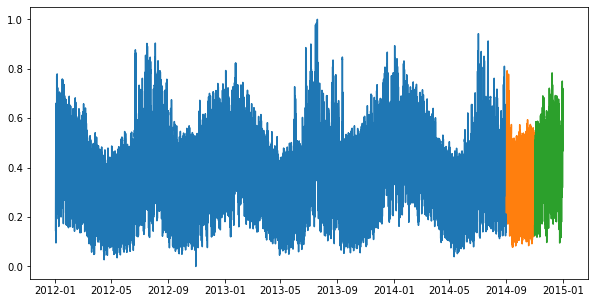

In [58]:
plt.figure(figsize=(10,5))
plt.plot(train['load_t-0'])
plt.plot(validation['load_t-0'])
plt.plot(test['load_t-0'])

### 문제, 답 분리

In [65]:
# train -----------------------------------------------

X_train = train.loc[:,'load_t-5':'load_t-0']
y_train = train['y_t+1']
# validation -----------------------------------------------
X_validation = validation.loc[:,'load_t-5':'load_t-0']
y_validation = validation['y_t+1']
# test -----------------------------------------------
X_test = test.loc[:,'load_t-5':'load_t-0']
y_test = test['y_t+1']

In [68]:
X_train.shape
# --> RNN 형태에 맞추기 위해 reshape
X_train = X_train.values.reshape(X_train.shape[0],6,1)
X_validation = X_validation.values.reshape(X_validation.shape[0],6,1)
X_test = X_test.values.reshape(X_test.shape[0],6,1)

In [69]:
print(X_train.shape, y_train.shape)
print(X_validation.shape, y_validation.shape)
print(X_test.shape, y_test.shape)

(23371, 6, 1) (23371,)
(1464, 6, 1) (1464,)
(1463, 6, 1) (1463,)


### 모델링

In [79]:
# RNN SET( n개의 글자, n개의 timestep, n개의 feature)
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM

model1 = Sequential()

model1.add(LSTM(128, input_shape=(6,1)))
model1.add(Dense(1)) # 회귀때는 활성화 함수 지정 X

model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [80]:
model1.compile(loss = 'mse',optimizer='adam')

In [81]:
hist = model1.fit(X_train,y_train,
           validation_data = (X_validation, y_validation),
           epochs=20)

Train on 23371 samples, validate on 1464 samples
Epoch 1/20
23371/23371 [==============================] - 3s 148us/sample - loss: 0.0074 - val_loss: 0.0016
Epoch 2/20
23371/23371 [==============================] - 2s 78us/sample - loss: 0.0013 - val_loss: 7.6112e-04
Epoch 3/20
23371/23371 [==============================] - 2s 82us/sample - loss: 7.2887e-04 - val_loss: 6.8619e-04
Epoch 4/20
23371/23371 [==============================] - 2s 81us/sample - loss: 6.2999e-04 - val_loss: 5.2479e-04
Epoch 5/20
23371/23371 [==============================] - 2s 82us/sample - loss: 6.0052e-04 - val_loss: 5.0764e-04
Epoch 6/20
23371/23371 [==============================] - 2s 83us/sample - loss: 5.8936e-04 - val_loss: 5.1455e-04
Epoch 7/20
23371/23371 [==============================] - 2s 81us/sample - loss: 5.7132e-04 - val_loss: 5.6906e-04
Epoch 8/20
23371/23371 [==============================] - 2s 83us/sample - loss: 5.5607e-04 - val_loss: 5.8243e-04
Epoch 9/20
23371/23371 [==================

### 결과 확인

In [82]:
model1.evaluate(X_test,y_test)

1463/1463 [==============================] - 0s 45us/sample - loss: 3.9608e-04


0.0003960798086109301

In [87]:
pre = model1.predict(X_test)

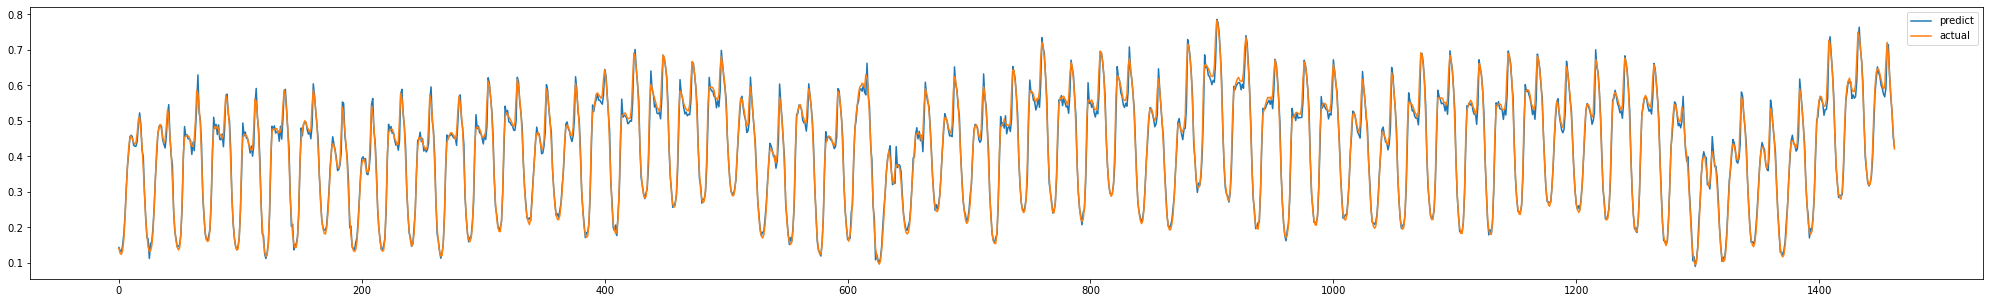

In [95]:
plt.figure(figsize=(35,5)) 
plt.plot(pre, label='predict')
plt.plot(y_test.values, label = 'actual')
plt.legend()
plt.show()

### temp도 해보장

In [195]:
energy = pd.read_csv('data/energy.csv', 
                     parse_dates=['timestamp'],
                    index_col='timestamp')

In [196]:
energy.head()

,load,temp
timestamp,,
2012-01-01 00:00:00,2698.0,32.000000
2012-01-01 01:00:00,2558.0,32.666667
2012-01-01 02:00:00,2444.0,30.000000
2012-01-01 03:00:00,2402.0,31.000000
2012-01-01 04:00:00,2403.0,32.000000


In [197]:
#from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
result = scaler.fit_transform(energy)
result

array([[0.22157165, 0.4202454 ],
       [0.17842835, 0.42638037],
       [0.14329738, 0.40184049],
       ...,
       [0.52141757, 0.28220859],
       [0.46841294, 0.26687117],
       [0.42095532, 0.26687117]])

In [213]:
for i in range(len(result)) :
    energy['load'][i] = result[i,0]
    energy['temp'][i] = result[i,1]    

In [215]:
energy['load']

timestamp
2012-01-01 00:00:00    0.221572
2012-01-01 01:00:00    0.178428
2012-01-01 02:00:00    0.143297
2012-01-01 03:00:00    0.130354
2012-01-01 04:00:00    0.130663
                         ...   
2014-12-31 19:00:00    0.626502
2014-12-31 20:00:00    0.578428
2014-12-31 21:00:00    0.521418
2014-12-31 22:00:00    0.468413
2014-12-31 23:00:00    0.420955
Name: load, Length: 26304, dtype: float64

In [216]:
energy_shifted = energy.copy()
energy_shifted['y_t+1'] = energy_shifted['load'].shift(-1, freq='H')

In [217]:
energy_shifted.head()

,load,temp,y_t+1
timestamp,,,
2012-01-01 00:00:00,0.221572,0.420245,0.178428
2012-01-01 01:00:00,0.178428,0.426380,0.143297
2012-01-01 02:00:00,0.143297,0.401840,0.130354
2012-01-01 03:00:00,0.130354,0.411043,0.130663
2012-01-01 04:00:00,0.130663,0.420245,0.146071


In [218]:
energy_shifted['load_t-5'] = energy_shifted['load'].shift(5, freq='H')
energy_shifted['temp_t-5'] = energy_shifted['temp'].shift(5, freq='H')
energy_shifted['load_t-4'] = energy_shifted['load'].shift(4, freq='H')
energy_shifted['temp_t-4'] = energy_shifted['temp'].shift(4, freq='H')
energy_shifted['load_t-3'] = energy_shifted['load'].shift(3, freq='H')
energy_shifted['temp_t-3'] = energy_shifted['temp'].shift(3, freq='H')
energy_shifted['load_t-2'] = energy_shifted['load'].shift(2, freq='H')
energy_shifted['temp_t-2'] = energy_shifted['temp'].shift(2, freq='H')
energy_shifted['load_t-1'] = energy_shifted['load'].shift(1, freq='H')
energy_shifted['temp_t-1'] = energy_shifted['temp'].shift(1, freq='H')
energy_shifted['load_t-0'] = energy_shifted['load'].shift(0, freq='H')
energy_shifted['temp_t-0'] = energy_shifted['temp'].shift(0, freq='H')

In [219]:
energy_shifted.head()

,load,temp,y_t+1,load_t-5,temp_t-5,load_t-4,temp_t-4,load_t-3,temp_t-3,load_t-2,temp_t-2,load_t-1,temp_t-1,load_t-0,temp_t-0
timestamp,,,,,,,,,,,,,,,
2012-01-01 00:00:00,0.221572,0.420245,0.178428,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.221572,0.420245
2012-01-01 01:00:00,0.178428,0.426380,0.143297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.221572,0.420245,0.178428,0.426380
2012-01-01 02:00:00,0.143297,0.401840,0.130354,NaN,NaN,NaN,NaN,NaN,NaN,0.221572,0.420245,0.178428,0.426380,0.143297,0.401840
2012-01-01 03:00:00,0.130354,0.411043,0.130663,NaN,NaN,NaN,NaN,0.221572,0.420245,0.178428,0.426380,0.143297,0.401840,0.130354,0.411043
2012-01-01 04:00:00,0.130663,0.420245,0.146071,NaN,NaN,0.221572,0.420245,0.178428,0.426380,0.143297,0.401840,0.130354,0.411043,0.130663,0.420245


In [220]:
del energy_shifted['temp']
del energy_shifted['load']

In [221]:
energy_shifted.dropna(inplace=True)

In [222]:
validation_start = '2014-09-01 00:00:00'
test_start = '2014-11-01 00:00:00'

In [223]:
train = energy_shifted.loc[energy_shifted.index<validation_start]
validation = energy_shifted.loc[(energy_shifted.index >= validation_start) & (energy_shifted.index<test_start)]
test = energy_shifted.loc[energy_shifted.index >= test_start]

In [224]:
train.shape, validation.shape, test.shape

((23371, 13), (1464, 13), (1463, 13))

In [225]:
energy_shifted.head()

,y_t+1,load_t-5,temp_t-5,load_t-4,temp_t-4,load_t-3,temp_t-3,load_t-2,temp_t-2,load_t-1,temp_t-1,load_t-0,temp_t-0
timestamp,,,,,,,,,,,,,
2012-01-01 05:00:00,0.179045,0.221572,0.420245,0.178428,0.426380,0.143297,0.401840,0.130354,0.411043,0.130663,0.420245,0.146071,0.414110
2012-01-01 06:00:00,0.228043,0.178428,0.426380,0.143297,0.401840,0.130354,0.411043,0.130663,0.420245,0.146071,0.414110,0.179045,0.401840
2012-01-01 07:00:00,0.288752,0.143297,0.401840,0.130354,0.411043,0.130663,0.420245,0.146071,0.414110,0.179045,0.401840,0.228043,0.392638
2012-01-01 08:00:00,0.346995,0.130354,0.411043,0.130663,0.420245,0.146071,0.414110,0.179045,0.401840,0.228043,0.392638,0.288752,0.392638
2012-01-01 09:00:00,0.368259,0.130663,0.420245,0.146071,0.414110,0.179045,0.401840,0.228043,0.392638,0.288752,0.392638,0.346995,0.432515


In [226]:
# train -----------------------------------------------
X_train = train.iloc[:,1:]
y_train = train['y_t+1']
# validation -----------------------------------------------
X_validation = validation.iloc[:,1:]
y_validation = validation['y_t+1']
# test -----------------------------------------------
X_test = test.iloc[:,1:]
y_test = test['y_t+1']

In [227]:
X_train.head()

,load_t-5,temp_t-5,load_t-4,temp_t-4,load_t-3,temp_t-3,load_t-2,temp_t-2,load_t-1,temp_t-1,load_t-0,temp_t-0
timestamp,,,,,,,,,,,,
2012-01-01 05:00:00,0.221572,0.420245,0.178428,0.426380,0.143297,0.401840,0.130354,0.411043,0.130663,0.420245,0.146071,0.414110
2012-01-01 06:00:00,0.178428,0.426380,0.143297,0.401840,0.130354,0.411043,0.130663,0.420245,0.146071,0.414110,0.179045,0.401840
2012-01-01 07:00:00,0.143297,0.401840,0.130354,0.411043,0.130663,0.420245,0.146071,0.414110,0.179045,0.401840,0.228043,0.392638
2012-01-01 08:00:00,0.130354,0.411043,0.130663,0.420245,0.146071,0.414110,0.179045,0.401840,0.228043,0.392638,0.288752,0.392638
2012-01-01 09:00:00,0.130663,0.420245,0.146071,0.414110,0.179045,0.401840,0.228043,0.392638,0.288752,0.392638,0.346995,0.432515


In [228]:
X_train

,load_t-5,temp_t-5,load_t-4,temp_t-4,load_t-3,temp_t-3,load_t-2,temp_t-2,load_t-1,temp_t-1,load_t-0,temp_t-0
timestamp,,,,,,,,,,,,
2012-01-01 05:00:00,0.221572,0.420245,0.178428,0.426380,0.143297,0.401840,0.130354,0.411043,0.130663,0.420245,0.146071,0.414110
2012-01-01 06:00:00,0.178428,0.426380,0.143297,0.401840,0.130354,0.411043,0.130663,0.420245,0.146071,0.414110,0.179045,0.401840
2012-01-01 07:00:00,0.143297,0.401840,0.130354,0.411043,0.130663,0.420245,0.146071,0.414110,0.179045,0.401840,0.228043,0.392638
2012-01-01 08:00:00,0.130354,0.411043,0.130663,0.420245,0.146071,0.414110,0.179045,0.401840,0.228043,0.392638,0.288752,0.392638
2012-01-01 09:00:00,0.130663,0.420245,0.146071,0.414110,0.179045,0.401840,0.228043,0.392638,0.288752,0.392638,0.346995,0.432515
...,...,...,...,...,...,...,...,...,...,...,...,...
2014-08-31 19:00:00,0.556857,0.849693,0.565177,0.849693,0.579353,0.840491,0.603082,0.840491,0.609553,0.831288,0.613251,0.812883
2014-08-31 20:00:00,0.565177,0.849693,0.579353,0.840491,0.603082,0.840491,0.609553,0.831288,0.613251,0.812883,0.582435,0.806748
2014-08-31 21:00:00,0.579353,0.840491,0.603082,0.840491,0.609553,0.831288,0.613251,0.812883,0.582435,0.806748,0.512789,0.797546


In [229]:
y_train

timestamp
2012-01-01 05:00:00    0.179045
2012-01-01 06:00:00    0.228043
2012-01-01 07:00:00    0.288752
2012-01-01 08:00:00    0.346995
2012-01-01 09:00:00    0.368259
                         ...   
2014-08-31 19:00:00    0.582435
2014-08-31 20:00:00    0.512789
2014-08-31 21:00:00    0.427119
2014-08-31 22:00:00    0.344530
2014-08-31 23:00:00    0.279507
Name: y_t+1, Length: 23371, dtype: float64

In [230]:
X_train.shape
# --> RNN 형태에 맞추기 위해 reshape
X_train = X_train.values.reshape(X_train.shape[0],6,2)
X_validation = X_validation.values.reshape(X_validation.shape[0],6,2)
X_test = X_test.values.reshape(X_test.shape[0],6,2)

In [231]:
X_train

array([[[0.22157165, 0.4202454 ],
        [0.17842835, 0.42638037],
        [0.14329738, 0.40184049],
        [0.13035439, 0.41104294],
        [0.13066256, 0.4202454 ],
        [0.14607088, 0.41411043]],

       [[0.17842835, 0.42638037],
        [0.14329738, 0.40184049],
        [0.13035439, 0.41104294],
        [0.13066256, 0.4202454 ],
        [0.14607088, 0.41411043],
        [0.17904468, 0.40184049]],

       [[0.14329738, 0.40184049],
        [0.13035439, 0.41104294],
        [0.13066256, 0.4202454 ],
        [0.14607088, 0.41411043],
        [0.17904468, 0.40184049],
        [0.22804314, 0.39263804]],

       ...,

       [[0.57935285, 0.8404908 ],
        [0.60308166, 0.8404908 ],
        [0.60955316, 0.83128834],
        [0.61325116, 0.81288344],
        [0.58243451, 0.80674847],
        [0.51278891, 0.79754601]],

       [[0.60308166, 0.8404908 ],
        [0.60955316, 0.83128834],
        [0.61325116, 0.81288344],
        [0.58243451, 0.80674847],
        [0.51278891, 0.7975

In [232]:
print(X_train.shape)

(23371, 6, 2)


In [233]:
model2 = Sequential()

model2.add(LSTM(128, input_shape=(6,2)))
model2.add(Dense(1)) # 회귀때는 활성화 함수 지정 X

model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 128)               67072     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 67,201
Trainable params: 67,201
Non-trainable params: 0
_________________________________________________________________


In [234]:
model2.compile(loss = 'mse',optimizer='adam')

In [235]:
hist = model2.fit(X_train,y_train,
           validation_data = (X_validation, y_validation),
           epochs=20)

Train on 23371 samples, validate on 1464 samples
Epoch 1/20
23371/23371 [==============================] - 4s 160us/sample - loss: 0.0068 - val_loss: 0.0012
Epoch 2/20
23371/23371 [==============================] - 2s 81us/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 3/20
23371/23371 [==============================] - 2s 83us/sample - loss: 6.9711e-04 - val_loss: 4.6386e-04
Epoch 4/20
23371/23371 [==============================] - 2s 86us/sample - loss: 6.0730e-04 - val_loss: 4.5752e-04
Epoch 5/20
23371/23371 [==============================] - 2s 86us/sample - loss: 5.5765e-04 - val_loss: 5.9867e-04
Epoch 6/20
23371/23371 [==============================] - 2s 87us/sample - loss: 5.4181e-04 - val_loss: 4.5268e-04
Epoch 7/20
23371/23371 [==============================] - 2s 87us/sample - loss: 5.3764e-04 - val_loss: 5.2768e-04
Epoch 8/20
23371/23371 [==============================] - 2s 86us/sample - loss: 5.3388e-04 - val_loss: 4.5117e-04
Epoch 9/20
23371/23371 [======================

In [236]:
pre = model2.predict(X_test)

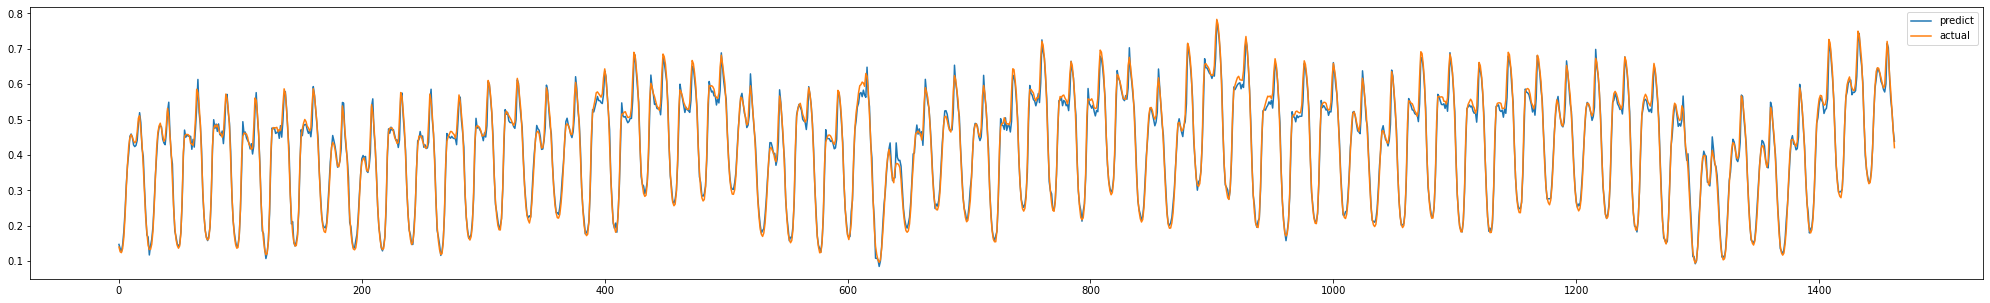

In [237]:
plt.figure(figsize=(35,5)) 
plt.plot(pre, label='predict')
plt.plot(y_test.values, label = 'actual')
plt.legend()
plt.show()